In [8]:
import os
data_dir = './dataset/jena-climate'

fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [9]:
# Load data into a numpy matrix
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

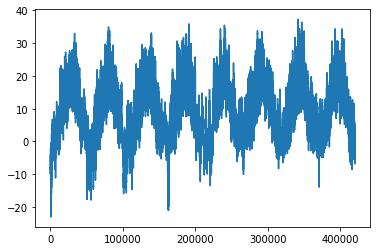

In [10]:
# Plot temperature data (all data (8 years))
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

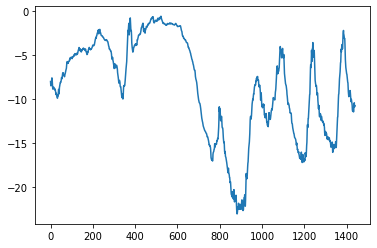

In [11]:
# First 10 days of temperature (data is recorded every 10 mins)
plt.plot(range(1440), temp[:1440])

In [12]:
NUM_SAMPLES = 20000 # Will use only 3-4 months of data to simplify the processing
VAL_SAMPLES = 10000

# Normalize variables
mean = float_data[:NUM_SAMPLES].mean(axis=0)
float_data -= mean
std = float_data[:NUM_SAMPLES].std(axis=0)
float_data /= std

### Use a generator to prepare the data used for training on the fly

Parameters:
- data — The original array of floating-point data, normalized.
- lookback — How many timesteps back the input data should go.
- delay — How many timesteps in the future the target should be.
- min_index and max_index — Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
- shuffle — Whether to shuffle the samples or draw them in chronological order.
- batch_size — The number of samples per batch.
- step — The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw one data point every hour.

In [13]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                        min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [14]:
# Creating the generators for training, validation and testing

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=NUM_SAMPLES,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=NUM_SAMPLES+1,
                    max_index=NUM_SAMPLES+VAL_SAMPLES,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=NUM_SAMPLES+VAL_SAMPLES,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# How many steps to draw from val_gen in order to see the entire validation set
val_steps = ((NUM_SAMPLES+VAL_SAMPLES) - (NUM_SAMPLES+1) - lookback)
test_steps = (len(float_data) - (NUM_SAMPLES+VAL_SAMPLES) - lookback)


In [10]:
# Trying a naive predicting algorithm, that will always predict the temperature to be the same as the one 24 hours before, to see its mean absolute error (MAE).
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    return np.mean(batch_maes)

mae = evaluate_naive_method()
# Unnormalize the MAE
celsius_mae = mae * std[1]
print('MAE: %.2f ºC' %celsius_mae)

KeyboardInterrupt: 

In [15]:
# Try with a simple DL aproach

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen, steps_per_epoch=50, epochs=3, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/3
48/50 [===========================>..] - ETA: 0s - loss: 2.3072

KeyboardInterrupt: 

In [ ]:
from util import plot_history

plot_history(history)

In [62]:
# Testing a RNN model (GRU, a simpler version of LSTM, more performant)

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                                      steps_per_epoch=50,
                                      epochs=3,
                                      validation_data=val_gen,
                                      validation_steps=val_steps)

Epoch 1/3
50/50 [==============================] - 367s 7s/step - loss: 0.3380 - val_loss: 0.3866
Epoch 2/3
50/50 [==============================] - 358s 7s/step - loss: 0.3083 - val_loss: 0.3250
Epoch 3/3
50/50 [==============================] - 374s 7s/step - loss: 0.2916 - val_loss: 0.3181


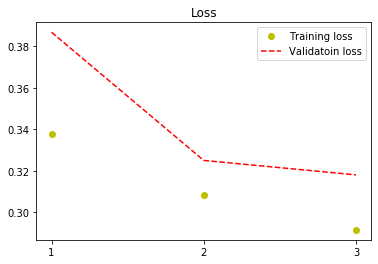

KeyError: 'acc'

In [63]:
plot_history(history)

In [66]:
# Adding dropout to fight overfitting
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
    dropout=0.2,
    recurrent_dropout=0.2,
    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                      steps_per_epoch=50,
                                      epochs=3,
                                      validation_data=val_gen,
                                      validation_steps=val_steps)


Epoch 1/3


KeyboardInterrupt: 

In [ ]:
plot_history(history)

In [ ]:
# As the model is not overfitting anymore, it is a good idea to stack another recurrent layer
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
    dropout=0.1,
    recurrent_dropout=0.5, return_sequences=True,
    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu', dropout=0.1,
    recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=50,
                              epochs=3,
                              validation_data=vbbbal_gen,
                              validation_steps=val_steps)


In [2]:
# Trying a reverse-order sequence training with the IMDB example
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy',
              metrics=['acc'])
    
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

history = model.fit(x_train, y_train, epochs=10,
    batch_size=128, validation_split=0.2)


Epoch 1/10
4/4 [==============================] - 272s 68s/step - loss: 0.6933 - acc: 0.4800 - val_loss: 0.6919 - val_acc: 0.5400
Epoch 2/10
4/4 [==============================] - 72s 18s/step - loss: 0.6887 - acc: 0.6600 - val_loss: 0.6908 - val_acc: 0.5400
Epoch 3/10
4/4 [==============================] - 65s 16s/step - loss: 0.6846 - acc: 0.7025 - val_loss: 0.6900 - val_acc: 0.5400
Epoch 4/10
4/4 [==============================] - 60s 15s/step - loss: 0.6799 - acc: 0.7050 - val_loss: 0.6899 - val_acc: 0.5400
Epoch 5/10
4/4 [==============================] - 61s 15s/step - loss: 0.6752 - acc: 0.7050 - val_loss: 0.6900 - val_acc: 0.5400
Epoch 6/10
4/4 [==============================] - 61s 15s/step - loss: 0.6692 - acc: 0.7075 - val_loss: 0.6901 - val_acc: 0.5400
Epoch 7/10
4/4 [==============================] - 61s 15s/step - loss: 0.6629 - acc: 0.7000 - val_loss: 0.6900 - val_acc: 0.5400
Epoch 8/10
4/4 [==============================] - 62s 16s/step - loss: 0.6559 - acc: 0.7025 - va

### Using a bidirectional RNN to test data in different orders

In [4]:
# On IMDB data
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train,
    epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
4/4 [==============================] - 361s 90s/step - loss: 0.6930 - acc: 0.5350 - val_loss: 0.6927 - val_acc: 0.5400
Epoch 2/10
4/4 [==============================] - 90s 22s/step - loss: 0.6919 - acc: 0.6100 - val_loss: 0.6927 - val_acc: 0.5400
Epoch 3/10
4/4 [==============================] - 87s 22s/step - loss: 0.6903 - acc: 0.6125 - val_loss: 0.6919 - val_acc: 0.5400
Epoch 4/10
4/4 [==============================] - 86s 22s/step - loss: 0.6886 - acc: 0.6500 - val_loss: 0.6919 - val_acc: 0.5400
Epoch 5/10
4/4 [==============================] - 92s 23s/step - loss: 0.6866 - acc: 0.6525 - val_loss: 0.6914 - val_acc: 0.5400
Epoch 6/10
4/4 [==============================] - 90s 22s/step - loss: 0.6839 - acc: 0.6700 - val_loss: 0.6910 - val_acc: 0.5400
Epoch 7/10
4/4 [==============================] - 88s 22s/step - loss: 0.6807 - acc: 0.6800 - val_loss: 0.6908 - val_acc: 0.5400
Epoch 8/10
4/4 [==============================] - 88s 22s/step - loss: 0.6775 - acc: 0.6900 - va

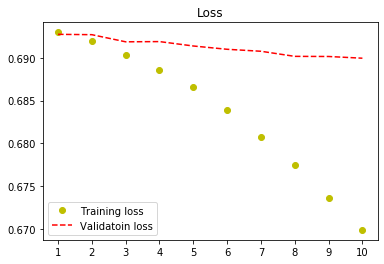

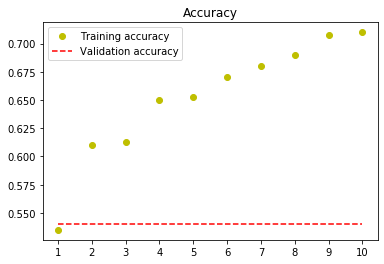

In [7]:
from util import plot_history
plot_history(history)

In [15]:
# On temperature data
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
500/500 [==============================] - ETA: 0s - loss: 0.2664

KeyboardInterrupt: 